# Feature penalties tutotial

[Cost efficient gradient boosting](https://papers.nips.cc/paper/6753-cost-efficient-gradient-boosting.pdf) is supposed to build models with less applying time. It's achieved due to less usage of expensive-to-compute features. Feature computation time is specified through *per-object-feature-penalties* and *first-feature-use-penalties* (if feature is computed once for all objects) parameters. You can scale all feature penalties at once through *penalties-coefficient* param.

Let's create a synthetic dataset to demonstrate feature penalties influence.

In [1]:
import numpy as np
import sklearn
import catboost
import lightgbm

In [2]:
seed = 33
np.random.seed(seed)

CEGB claims to produce trees with deep branches but low expected depth and feature cost, so let's try to build it.

Let's create a synthetic dataset for classification. Each next feature is supposed to be more costly than previous. Half of the dataset data label depends on the first feature, half of the rest data label depends on the second feature and so on. So a perfect model would use only *n_features* splits with each feature. 

In [3]:
def generate_dataset(n_objects, n_features):
    X = np.random.rand(n_objects, n_features)
    y = np.zeros(n_objects, dtype=int)
    half_len = n_objects // 2
    
    def get_target(lvl):
        return 0 if lvl % 2 else 1
    
    for lvl in range(n_features):
        X[:half_len, lvl] = X[:half_len, lvl] / 2
        X[half_len:2*half_len, lvl] = X[half_len:2*half_len, lvl] / 2 + 0.5
        y[half_len:2*half_len] = get_target(lvl)
        half_len //= 2
    half_len *= 2
    y[:half_len] = get_target(n_features)
    X, y = sklearn.utils.shuffle(X, y, random_state=seed)
    return catboost.Pool(X, y, cat_features=[], feature_names=list(map(str, range(n_features))))

In [4]:
n_objects_small=2**13
n_features_small=3

In [5]:
small_pool = generate_dataset(n_objects_small, n_features_small)

In [6]:
iterations_count=10

In [7]:
common_params = {
    'random_seed': seed,
    'grow_policy': 'Lossguide',
    'objective': 'Logloss',
}

In [8]:
clf_wo_penalties = catboost.CatBoostClassifier(
    **common_params,
    depth=n_features_small,
    iterations=iterations_count
)

In [9]:
clf_wo_penalties.fit(small_pool)

Learning rate set to 0.5
0:	learn: 0.3269160	total: 69.3ms	remaining: 624ms
1:	learn: 0.1830209	total: 88ms	remaining: 352ms
2:	learn: 0.1074017	total: 108ms	remaining: 251ms
3:	learn: 0.0645294	total: 128ms	remaining: 192ms
4:	learn: 0.0401535	total: 148ms	remaining: 148ms
5:	learn: 0.0257087	total: 167ms	remaining: 111ms
6:	learn: 0.0172086	total: 186ms	remaining: 79.8ms
7:	learn: 0.0115311	total: 206ms	remaining: 51.5ms
8:	learn: 0.0081579	total: 226ms	remaining: 25.1ms
9:	learn: 0.0066731	total: 246ms	remaining: 0us


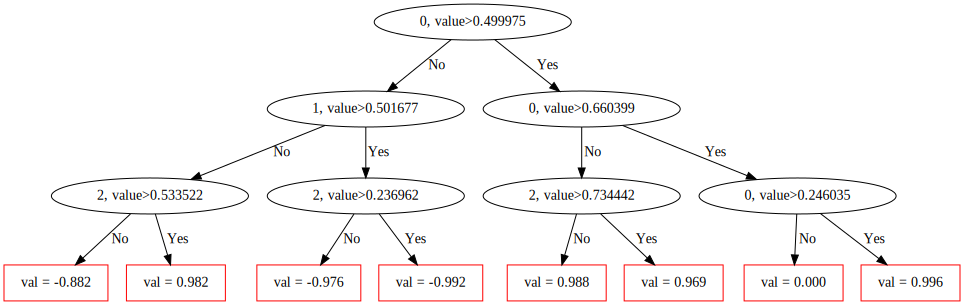

In [10]:
clf_wo_penalties.plot_tree(tree_idx=0, pool=small_pool)

We can see that the model without feature penalties uses some extra splits except three required ones, including splits with "costly features".

In [11]:
def get_penalties(n_features, base=1.02):
    return list([base**lvl for lvl in range(n_features)])

In [12]:
clf_with_penalties_small = catboost.CatBoostClassifier(
    **common_params,
    depth=n_features_small,
    iterations=iterations_count,
    penalties_coefficient=0.001,
    per_object_feature_penalties=get_penalties(n_features_small)
)

In [13]:
clf_with_penalties_small.fit(small_pool)

Learning rate set to 0.5
0:	learn: 0.3261432	total: 19.8ms	remaining: 178ms
1:	learn: 0.1822131	total: 39.1ms	remaining: 156ms
2:	learn: 0.1060415	total: 59ms	remaining: 138ms
3:	learn: 0.0644842	total: 75.9ms	remaining: 114ms
4:	learn: 0.0398788	total: 91.4ms	remaining: 91.4ms
5:	learn: 0.0250120	total: 109ms	remaining: 72.7ms
6:	learn: 0.0166103	total: 128ms	remaining: 54.7ms
7:	learn: 0.0109570	total: 144ms	remaining: 36.1ms
8:	learn: 0.0077417	total: 161ms	remaining: 17.9ms
9:	learn: 0.0055647	total: 180ms	remaining: 0us


We can see that the model with penalties got slightly better results.

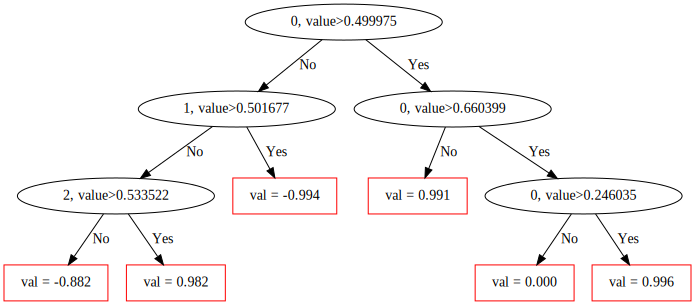

In [14]:
clf_with_penalties_small.plot_tree(tree_idx=0, pool=small_pool)

We can see that model with penalties doesn't have unnecessary splits with "costly" features 1 and 2.

**Note**: Too low feature penalties may have no effect on model while too big feature penalties may significantly decrease model quality. Be careful to use it!

LightGBM also supports feature penalties, although we couldn't find an improving penalties parameters combination. We provide here a default algorithm work.

In [15]:
lgb_param={
    'random_state': seed,
    'metric': 'binary_logloss',
    'n_estimators': iterations_count,
}

In [16]:
lgb_clf_wo_penalties = lightgbm.LGBMClassifier(max_depth=n_features_small, **lgb_param)
lgb_clf_wo_penalties.fit(small_pool.get_features(), small_pool.get_label(), verbose=1, eval_set=[(small_pool.get_features(), small_pool.get_label())])

[1]	valid_0's binary_logloss: 0.566796
[2]	valid_0's binary_logloss: 0.491112
[3]	valid_0's binary_logloss: 0.428904
[4]	valid_0's binary_logloss: 0.376786
[5]	valid_0's binary_logloss: 0.332483
[6]	valid_0's binary_logloss: 0.294491
[7]	valid_0's binary_logloss: 0.261591
[8]	valid_0's binary_logloss: 0.232979
[9]	valid_0's binary_logloss: 0.207904
[10]	valid_0's binary_logloss: 0.185897


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=3,
               metric='binary_logloss', min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=10,
               n_jobs=-1, num_leaves=31, objective=None, random_state=33,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

We can see that LightGBM model with corresponding parameters gave worse results.

### Method performance.

In [17]:
n_objects_big=2**17
n_features_big=5

In [18]:
big_pool = generate_dataset(n_objects_big, n_features_big)

In [19]:
clf_with_penalties_big = catboost.CatBoostClassifier(
    **common_params,
    depth=n_features_big,
    iterations=iterations_count,
    penalties_coefficient=0.001,
    per_object_feature_penalties=get_penalties(n_features_big)
)

In [20]:
%timeit -r 5 clf_wo_penalties.fit(big_pool, verbose=False)

1.47 s ± 9.64 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [21]:
%timeit -r 5 clf_with_penalties_big.fit(big_pool, verbose=False)

1.45 s ± 11.4 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [22]:
big_pool_features = big_pool.get_features()
big_pool_label = big_pool.get_label()

In [23]:
%timeit -r 5 lgb_clf_wo_penalties.fit(big_pool_features, big_pool_label)

152 ms ± 2.08 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)


We can see that catboost models with penalties and without them have similar performance while lightGBM model is learning faster.

In [24]:
%timeit -r 5 clf_wo_penalties.predict(big_pool)

62.2 ms ± 1.53 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)


In [25]:
%timeit -r 5 clf_with_penalties_big.predict(big_pool)

59.4 ms ± 352 µs per loop (mean ± std. dev. of 5 runs, 10 loops each)


In [26]:
%timeit -r 5 lgb_clf_wo_penalties.predict(big_pool_features)

25.5 ms ± 2.79 ms per loop (mean ± std. dev. of 5 runs, 10 loops each)


We can see that applying of catboost models with penalties and without them have similar performance while lightGBM model is applying faster.

Right now there is no interface in catboost or lightGBM to provide features by request. Although there is a possibility to build low expected depth trees with lossguide growing policy.